In [1]:
# Cell 1: Import required libraries for CNN training
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm.auto import tqdm
import time
import json
from scipy.signal import spectrogram as sp_spectrogram

# Verify successful library imports
print("Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"MPS (Metal) available: {torch.backends.mps.is_available()}")
print(f"MPS built: {torch.backends.mps.is_built()}")

# Configure device for optimal performance
# Priority order: MPS (Apple Silicon), CUDA (NVIDIA), CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
    print("MacBook Air M4 with 10 GPU cores detected")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

Libraries imported successfully
PyTorch version: 2.9.0
MPS (Metal) available: True
MPS built: True
Using MPS (Apple Silicon GPU)
MacBook Air M4 with 10 GPU cores detected


In [2]:
# Cell 2: Configuration for CNN training

# Directory paths for data and model storage
DATA_DIR = Path("/Volumes/Works/Individual_Project/spectrogram-files")
MODEL_DIR = Path("/Volumes/Works/Individual_Project/models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Data file locations
SPECTRO_PATH = DATA_DIR / "spectrograms.npy"
LABELS_PATH = DATA_DIR / "labels.npy"

# Training hyperparameters
BATCH_SIZE = 128  # Larger batch size leverages M4 parallel processing capabilities
LEARNING_RATE = 0.001
NUM_EPOCHS = 15
PATIENCE = 5  # Early stopping patience to prevent overfitting

# Dataset split ratios
TRAIN_RATIO = 0.80  # 80% for training
VAL_RATIO = 0.20    # 20% for validation

# Model architecture parameters
NUM_CLASSES = 2
INPUT_CHANNELS = 1

# Real-time detection threshold
CONFIDENCE_THRESHOLD = 0.95  # Minimum confidence level for positive detection

# Device configuration
DEVICE = device

# Enable MPS memory optimization for improved performance
torch.backends.mps.enable_increased_memory_limit = True

# Display configuration summary
print("Configuration Summary")
print("MPS Optimized for Apple M4")
print(f"Data directory: {DATA_DIR}")
print(f"Model directory: {MODEL_DIR}")
print(f"Device: {DEVICE}")
print(f"\nTraining parameters:")
print(f"  Batch size: {BATCH_SIZE} (optimized for M4)")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Max epochs: {NUM_EPOCHS}")
print(f"  Early stopping patience: {PATIENCE}")
print(f"\nData split:")
print(f"  Train: {TRAIN_RATIO*100:.0f}%")
print(f"  Validation: {VAL_RATIO*100:.0f}%")
print(f"\nReal-time detection:")
print(f"  Confidence threshold: {CONFIDENCE_THRESHOLD*100:.0f}%")
print(f"  Only detections above {CONFIDENCE_THRESHOLD*100:.0f}% confidence will be reported")

Configuration Summary
MPS Optimized for Apple M4
Data directory: /Volumes/Works/Individual_Project/spectrogram-files
Model directory: /Volumes/Works/Individual_Project/models
Device: mps

Training parameters:
  Batch size: 128 (optimized for M4)
  Learning rate: 0.001
  Max epochs: 15
  Early stopping patience: 5

Data split:
  Train: 80%
  Validation: 20%

Real-time detection:
  Confidence threshold: 95%
  Only detections above 95% confidence will be reported


In [3]:
# Cell 3: Custom PyTorch Dataset

class SpectrogramDataset(Dataset):
    """
    Custom Dataset class for loading and preprocessing spectrogram data.
    Optimized for MPS (Metal Performance Shaders) compatibility with Apple Silicon.
    """
    
    def __init__(self, spectrograms, labels, transform=None):
        """
        Initialize the dataset with spectrograms and corresponding labels.
        
        Args:
            spectrograms: numpy array of shape (N, H, W) containing spectrogram data
            labels: numpy array of binary labels (0 or 1)
            transform: optional transformation to apply to spectrograms
        """
        self.spectrograms = spectrograms
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        """Return the total number of samples in the dataset."""
        return len(self.labels)
    
    def __getitem__(self, idx):
        """
        Retrieve a single sample from the dataset.
        
        Args:
            idx: index of the sample to retrieve
            
        Returns:
            tuple: (spectrogram_tensor, label_tensor)
        """
        # Retrieve spectrogram and corresponding label
        spec = self.spectrograms[idx]
        label = self.labels[idx]
        
        # Convert to float32 for MPS compatibility
        if not isinstance(spec, np.ndarray):
            spec = np.array(spec, dtype=np.float32)
        else:
            spec = spec.astype(np.float32)
        
        # Add channel dimension for CNN input: (H, W) to (1, H, W)
        spec = np.expand_dims(spec, axis=0)
        
        # Convert numpy arrays to PyTorch tensors
        spec = torch.from_numpy(spec)
        label = torch.tensor(label, dtype=torch.long)
        
        # Apply optional transformations
        if self.transform:
            spec = self.transform(spec)
        
        return spec, label

# Display dataset configuration
print("SpectrogramDataset class defined")
print("  Input shape: (1025, 18)")
print("  Output shape: (1, 1025, 18)")
print("  Labels: 0 (Non_Human), 1 (Human)")
print("  MPS-compatible: Yes")

SpectrogramDataset class defined
  Input shape: (1025, 18)
  Output shape: (1, 1025, 18)
  Labels: 0 (Non_Human), 1 (Human)
  MPS-compatible: Yes


In [4]:
# Cell 4: CNN Model for Spectrogram Classification

class SpectrogramCNN(nn.Module):
    """
    Convolutional Neural Network for spectrogram-based binary classification.
    Optimized for Apple M4 MPS (Metal Performance Shaders).
    
    Architecture:
        - 4 convolutional blocks with batch normalization and dropout
        - 3 fully connected layers with dropout for regularization
        
    Input: (batch, 1, 1025, 18)
    Output: (batch, 2) - logits for binary classification [Non_Human, Human]
    """
    
    def __init__(self, num_classes=2, dropout_rate=0.5):
        """
        Initialize the CNN architecture.
        
        Args:
            num_classes: number of output classes (default: 2)
            dropout_rate: dropout probability for fully connected layers (default: 0.5)
        """
        super(SpectrogramCNN, self).__init__()
        
        # First convolutional block: 1 -> 32 channels
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces spatial dimensions by half: (32, 512, 9)
            nn.Dropout2d(0.25)
        )
        
        # Second convolutional block: 32 -> 64 channels
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: (64, 256, 4)
            nn.Dropout2d(0.25)
        )
        
        # Third convolutional block: 64 -> 128 channels
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: (128, 128, 2)
            nn.Dropout2d(0.25)
        )
        
        # Fourth convolutional block: 128 -> 256 channels
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 1)),  # Adaptive pooling to fixed size: (256, 4, 1)
            nn.Dropout2d(0.25)
        )
        
        # Fully connected classification layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 1, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x: input tensor of shape (batch, 1, 1025, 18)
            
        Returns:
            output tensor of shape (batch, num_classes)
        """
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.fc_layers(x)
        return x

# Initialize and display model architecture
model = SpectrogramCNN(num_classes=NUM_CLASSES)
print("CNN Model Architecture (MPS-Optimized)")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Verify model functionality with dummy input
dummy_input = torch.randn(1, 1, 1025, 18)
if DEVICE.type == 'mps':
    model_test = model.to(DEVICE)
    dummy_input_mps = dummy_input.to(DEVICE)
    dummy_output = model_test(dummy_input_mps)
    print(f"\nMPS Test:")
    print(f"  Model runs on MPS successfully")
    print(f"  Input shape: {dummy_input.shape}")
    print(f"  Output shape: {dummy_output.shape}")
else:
    dummy_output = model(dummy_input)
    print(f"\nTest forward pass:")
    print(f"  Input shape: {dummy_input.shape}")
    print(f"  Output shape: {dummy_output.shape}")

CNN Model Architecture (MPS-Optimized)
SpectrogramCNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.25, inplace=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.25, inplace=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [5]:
# Cell 5: Load and split dataset (80% train, 20% validation)

print("Loading Data")

# Load preprocessed spectrograms and labels from disk
print(f"\nLoading from:")
print(f"  {SPECTRO_PATH}")
print(f"  {LABELS_PATH}")

X = np.load(SPECTRO_PATH, allow_pickle=True)
y = np.load(LABELS_PATH)

print(f"\nLoaded:")
print(f"  Spectrograms: {len(X):,} samples")
print(f"  Labels: {len(y):,} samples")
print(f"  Shape: {X.shape}")

# Create PyTorch dataset wrapper
full_dataset = SpectrogramDataset(X, y)
dataset_size = len(full_dataset)

print(f"\nDataset created: {dataset_size:,} samples")

# Calculate train/validation split sizes
train_size = int(TRAIN_RATIO * dataset_size)
val_size = dataset_size - train_size

print(f"\nSplitting data (80/20):")
print(f"  Train: {train_size:,} samples ({TRAIN_RATIO*100:.0f}%)")
print(f"  Validation: {val_size:,} samples ({VAL_RATIO*100:.0f}%)")

# Perform random split with fixed seed for reproducibility
train_dataset, val_dataset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Create data loaders with MPS-optimized settings
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # MPS performs optimally with single-worker data loading
    pin_memory=False  # Memory pinning not required for MPS
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No shuffling needed for validation
    num_workers=0,
    pin_memory=False
)

print(f"\nData loaders created (MPS-optimized):")
print(f"  Train batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Batch size: {BATCH_SIZE}")

# Analyze class distribution in training and validation sets
train_labels = [y[i] for i in train_dataset.indices]
val_labels = [y[i] for i in val_dataset.indices]

from collections import Counter
train_dist = Counter(train_labels)
val_dist = Counter(val_labels)

print(f"\nClass distribution:")
print(f"  Train      - Human: {train_dist[1]:,} ({100*train_dist[1]/len(train_labels):.1f}%), Non_Human: {train_dist[0]:,} ({100*train_dist[0]/len(train_labels):.1f}%)")
print(f"  Validation - Human: {val_dist[1]:,} ({100*val_dist[1]/len(val_labels):.1f}%), Non_Human: {val_dist[0]:,} ({100*val_dist[0]/len(val_labels):.1f}%)")

print("\nData loading complete")

Loading Data

Loading from:
  /Volumes/Works/Individual_Project/spectrogram-files/spectrograms.npy
  /Volumes/Works/Individual_Project/spectrogram-files/labels.npy

Loaded:
  Spectrograms: 186,500 samples
  Labels: 186,500 samples
  Shape: (186500, 1025, 18)

Dataset created: 186,500 samples

Splitting data (80/20):
  Train: 149,200 samples (80%)
  Validation: 37,300 samples (20%)

Data loaders created (MPS-optimized):
  Train batches: 1166
  Validation batches: 292
  Batch size: 128

Class distribution:
  Train      - Human: 79,717 (53.4%), Non_Human: 69,483 (46.6%)
  Validation - Human: 19,783 (53.0%), Non_Human: 17,517 (47.0%)

Data loading complete


In [6]:
# Cell 6: Training and validation functions with class balancing

def train_epoch(model, loader, criterion, optimizer, device):
    """
    Execute one training epoch.
    
    Args:
        model: PyTorch model to train
        loader: DataLoader for training data
        criterion: loss function
        optimizer: optimization algorithm
        device: computation device (MPS/CUDA/CPU)
        
    Returns:
        tuple: (average_loss, accuracy_percentage)
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Training", leave=False)
    for inputs, labels in pbar:
        # Transfer data to device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Clear previous gradients
        optimizer.zero_grad()
        
        # Forward pass: compute predictions
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass: compute gradients and update weights
        loss.backward()
        optimizer.step()
        
        # Accumulate statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar with current metrics
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100*correct/total:.2f}%'
        })
    
    # Calculate epoch-level metrics
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc


def validate(model, loader, criterion, device):
    """
    Evaluate model performance on validation set.
    
    Args:
        model: PyTorch model to evaluate
        loader: DataLoader for validation data
        criterion: loss function
        device: computation device (MPS/CUDA/CPU)
        
    Returns:
        tuple: (average_loss, accuracy_percentage)
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Disable gradient computation for validation
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validation", leave=False)
        for inputs, labels in pbar:
            # Transfer data to device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass only
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Accumulate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar with current metrics
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100*correct/total:.2f}%'
            })
    
    # Calculate epoch-level metrics
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc


class LRSchedulerCallback:
    """
    Callback class to monitor and report learning rate changes during training.
    """
    def __init__(self, initial_lr):
        """
        Initialize callback with starting learning rate.
        
        Args:
            initial_lr: initial learning rate value
        """
        self.last_lr = initial_lr
    
    def check_and_print(self, optimizer):
        """
        Check if learning rate has changed and print notification.
        
        Args:
            optimizer: PyTorch optimizer instance
            
        Returns:
            float: current learning rate
        """
        current_lr = optimizer.param_groups[0]['lr']
        if current_lr != self.last_lr:
            print(f"\n  Learning rate reduced: {self.last_lr:.6f} -> {current_lr:.6f}")
            self.last_lr = current_lr
        return current_lr


# Display function summary
print("Training Functions Defined")
print("train_epoch() - Train for one epoch")
print("validate() - Validate the model")
print("LRSchedulerCallback - Track LR changes")
print("Optimized for Apple Silicon M4 with MPS")
print("Handles class imbalance with weighted loss")

Training Functions Defined
train_epoch() - Train for one epoch
validate() - Validate the model
LRSchedulerCallback - Track LR changes
Optimized for Apple Silicon M4 with MPS
Handles class imbalance with weighted loss


In [7]:
# Cell 7: Train the CNN model with progress tracking

print("Training CNN Model on Apple M4 (MPS)")

# Initialize model and transfer to device
model = SpectrogramCNN(num_classes=NUM_CLASSES)
model = model.to(DEVICE)

# Calculate class weights to handle imbalanced dataset
train_labels = [y[i] for i in train_dataset.indices]
from collections import Counter
class_counts = Counter(train_labels)

# Compute inverse frequency weights for balanced training
total_samples = len(train_labels)
class_weights = torch.FloatTensor([
    total_samples / class_counts[0],  # Non-Human weight
    total_samples / class_counts[1]   # Human weight
]).to(DEVICE)

# Normalize weights to sum to 2.0
class_weights = class_weights / class_weights.sum() * 2.0

print(f"\nClass Imbalance Handling")
print(f"Training set distribution:")
print(f"  Human (1):     {class_counts[1]:,} samples ({100*class_counts[1]/total_samples:.2f}%)")
print(f"  Non-Human (0): {class_counts[0]:,} samples ({100*class_counts[0]/total_samples:.2f}%)")
print(f"\nClass weights (to balance training):")
print(f"  Non-Human weight: {class_weights[0]:.4f}")
print(f"  Human weight:     {class_weights[1]:.4f}")
print(f"\nImbalance ratio: {class_counts[1]/class_counts[0]:.3f} (Human/Non-Human)")

# Initialize loss function with class weights and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Configure learning rate scheduler with plateau detection
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=5,
    min_lr=1e-6
)

# Initialize learning rate monitoring callback
lr_callback = LRSchedulerCallback(initial_lr=LEARNING_RATE)

# Initialize training history dictionary
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'learning_rates': []
}

# Initialize early stopping variables
best_val_loss = float('inf')
best_val_acc = 0.0
patience_counter = 0
best_model_path = MODEL_DIR / "best_model_mps.pth"

print(f"\nTraining Configuration")
print(f"Device: {DEVICE} (Apple M4 with 10 GPU cores)")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"\nDataset (80/20 split):")
print(f"  Training samples: {len(train_dataset):,}")
print(f"  Validation samples: {len(val_dataset):,}")
print(f"  Total: {len(train_dataset) + len(val_dataset):,}")
print(f"\nHyperparameters:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Initial learning rate: {LEARNING_RATE}")
print(f"  Max epochs: {NUM_EPOCHS}")
print(f"  Early stopping patience: {PATIENCE}")
print(f"  LR scheduler patience: 5")
print(f"  LR reduction factor: 0.5")
print(f"  Loss function: CrossEntropyLoss with class weights")
print(f"\nReal-time detection:")
print(f"  Confidence threshold: {CONFIDENCE_THRESHOLD*100:.0f}%")

input("\nPress Enter to start training... ")

start_time = time.time()
print(f"\nTraining started")

# Main training loop with progress tracking
epoch_pbar = tqdm(range(NUM_EPOCHS), desc="Overall Progress", position=0, leave=True)

for epoch in epoch_pbar:
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    epoch_start = time.time()
    
    # Execute training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    
    # Execute validation phase
    val_loss, val_acc = validate(model, val_loader, criterion, DEVICE)
    
    epoch_time = time.time() - epoch_start
    
    # Update learning rate based on validation loss
    scheduler.step(val_loss)
    
    # Monitor and log learning rate changes
    current_lr = lr_callback.check_and_print(optimizer)
    
    # Record metrics in history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['learning_rates'].append(current_lr)
    
    # Calculate estimated time to completion
    avg_epoch_time = (time.time() - start_time) / (epoch + 1)
    remaining_epochs = NUM_EPOCHS - (epoch + 1)
    eta_seconds = avg_epoch_time * remaining_epochs
    eta_minutes = eta_seconds / 60
    
    # Update progress bar with current metrics
    epoch_pbar.set_postfix({
        'Train Loss': f'{train_loss:.4f}',
        'Val Loss': f'{val_loss:.4f}',
        'Val Acc': f'{val_acc:.2f}%',
        'Best': f'{best_val_acc:.2f}%',
        'LR': f'{current_lr:.6f}'
    })
    
    # Display epoch summary
    print(f"\nEpoch {epoch+1} Results:")
    print(f"  Train Loss:    {train_loss:.4f}")
    print(f"  Train Acc:     {train_acc:.2f}%")
    print(f"  Val Loss:      {val_loss:.4f}")
    print(f"  Val Acc:       {val_acc:.2f}%")
    print(f"  Learning Rate: {current_lr:.6f}")
    print(f"  Epoch Time:    {epoch_time:.1f}s")
    print(f"  ETA:           {eta_minutes:.1f} min")
    
    # Check for improvement and save best model
    if val_loss < best_val_loss:
        improvement = best_val_loss - val_loss if best_val_loss != float('inf') else 0
        best_val_loss = val_loss
        best_val_acc = val_acc
        patience_counter = 0
        
        # Save model checkpoint with metadata
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'confidence_threshold': CONFIDENCE_THRESHOLD,
            'class_weights': class_weights.cpu().numpy().tolist(),
            'class_distribution': {
                'human': class_counts[1],
                'non_human': class_counts[0]
            },
            'device': 'mps'
        }, best_model_path)
        
        print(f"\n  New best model saved")
        if improvement > 0:
            print(f"     Val Loss: {val_loss:.4f} (improved by {improvement:.4f})")
        else:
            print(f"     Val Loss: {val_loss:.4f}")
        print(f"     Val Acc:  {val_acc:.2f}%")
        
        # Check if confidence threshold is met
        if val_acc >= CONFIDENCE_THRESHOLD * 100:
            print(f"     Above {CONFIDENCE_THRESHOLD*100:.0f}% threshold")
    else:
        patience_counter += 1
        print(f"\n  No improvement")
        print(f"     Patience: {patience_counter}/{PATIENCE}")
        print(f"     Best Val Loss: {best_val_loss:.4f}")
        print(f"     Best Val Acc:  {best_val_acc:.2f}%")
        
        # Trigger early stopping if patience exhausted
        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping triggered")
            print(f"  Stopped at epoch: {epoch+1}/{NUM_EPOCHS}")
            print(f"  Training time: {(time.time() - start_time)/60:.2f} minutes")
            print(f"\n  Best Model Performance:")
            print(f"     Val Loss: {best_val_loss:.4f}")
            print(f"     Val Acc:  {best_val_acc:.2f}%")
            epoch_pbar.close()
            break

# Close progress bar
epoch_pbar.close()

end_time = time.time()
training_time = end_time - start_time

# Display final training summary
print(f"\nTraining Complete")
print(f"\nTraining Statistics:")
print(f"   Total time: {training_time/60:.2f} minutes ({training_time/3600:.2f} hours)")
print(f"   Avg time per epoch: {training_time/(epoch+1):.1f} seconds")
print(f"   Total epochs: {epoch+1}")
print(f"\nBest Performance:")
print(f"   Validation Loss: {best_val_loss:.4f}")
print(f"   Validation Acc:  {best_val_acc:.2f}%")
print(f"\nClass Balance:")
print(f"   Training handled imbalanced dataset")
print(f"   Human: {class_counts[1]:,} | Non-Human: {class_counts[0]:,}")
print(f"   Used weighted loss for fair training")
print(f"\nModel Saved:")
print(f"   {best_model_path}")
print(f"   Size: {best_model_path.stat().st_size / (1024**2):.2f} MB")
print(f"\nConfidence Threshold: {CONFIDENCE_THRESHOLD*100:.0f}%")
if best_val_acc >= CONFIDENCE_THRESHOLD * 100:
    print(f"   Model meets confidence threshold")
else:
    print(f"   Model below confidence threshold ({best_val_acc:.2f}% < {CONFIDENCE_THRESHOLD*100:.0f}%)")
    print(f"   Consider training longer or adjusting hyperparameters")

Training CNN Model on Apple M4 (MPS)

Class Imbalance Handling
Training set distribution:
  Human (1):     79,717 samples (53.43%)
  Non-Human (0): 69,483 samples (46.57%)

Class weights (to balance training):
  Non-Human weight: 1.0686
  Human weight:     0.9314

Imbalance ratio: 1.147 (Human/Non-Human)

Training Configuration
Device: mps (Apple M4 with 10 GPU cores)
Model parameters: 979,522
Trainable parameters: 979,522

Dataset (80/20 split):
  Training samples: 149,200
  Validation samples: 37,300
  Total: 186,500

Hyperparameters:
  Batch size: 128
  Initial learning rate: 0.001
  Max epochs: 15
  Early stopping patience: 5
  LR scheduler patience: 5
  LR reduction factor: 0.5
  Loss function: CrossEntropyLoss with class weights

Real-time detection:
  Confidence threshold: 95%

Training started


Overall Progress:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 1/15


Training:   0%|          | 0/1166 [00:00<?, ?it/s]

Validation:   0%|          | 0/292 [00:00<?, ?it/s]


Epoch 1 Results:
  Train Loss:    0.1580
  Train Acc:     94.12%
  Val Loss:      0.0454
  Val Acc:       98.39%
  Learning Rate: 0.001000
  Epoch Time:    280.8s
  ETA:           65.5 min

  New best model saved
     Val Loss: 0.0454
     Val Acc:  98.39%
     Above 95% threshold

Epoch 2/15


Training:   0%|          | 0/1166 [00:00<?, ?it/s]

Validation:   0%|          | 0/292 [00:00<?, ?it/s]


Epoch 2 Results:
  Train Loss:    0.0593
  Train Acc:     98.07%
  Val Loss:      0.0285
  Val Acc:       99.02%
  Learning Rate: 0.001000
  Epoch Time:    277.8s
  ETA:           60.5 min

  New best model saved
     Val Loss: 0.0285 (improved by 0.0168)
     Val Acc:  99.02%
     Above 95% threshold

Epoch 3/15


Training:   0%|          | 0/1166 [00:00<?, ?it/s]

Validation:   0%|          | 0/292 [00:00<?, ?it/s]


Epoch 3 Results:
  Train Loss:    0.0454
  Train Acc:     98.53%
  Val Loss:      0.0253
  Val Acc:       99.15%
  Learning Rate: 0.001000
  Epoch Time:    286.8s
  ETA:           56.4 min

  New best model saved
     Val Loss: 0.0253 (improved by 0.0032)
     Val Acc:  99.15%
     Above 95% threshold

Epoch 4/15


Training:   0%|          | 0/1166 [00:00<?, ?it/s]

Validation:   0%|          | 0/292 [00:00<?, ?it/s]


Epoch 4 Results:
  Train Loss:    0.0380
  Train Acc:     98.78%
  Val Loss:      0.0247
  Val Acc:       99.18%
  Learning Rate: 0.001000
  Epoch Time:    295.5s
  ETA:           52.3 min

  New best model saved
     Val Loss: 0.0247 (improved by 0.0005)
     Val Acc:  99.18%
     Above 95% threshold

Epoch 5/15


Training:   0%|          | 0/1166 [00:00<?, ?it/s]

Validation:   0%|          | 0/292 [00:00<?, ?it/s]


Epoch 5 Results:
  Train Loss:    0.0349
  Train Acc:     98.86%
  Val Loss:      0.0206
  Val Acc:       99.26%
  Learning Rate: 0.001000
  Epoch Time:    301.5s
  ETA:           48.1 min

  New best model saved
     Val Loss: 0.0206 (improved by 0.0041)
     Val Acc:  99.26%
     Above 95% threshold

Epoch 6/15


Training:   0%|          | 0/1166 [00:00<?, ?it/s]

Validation:   0%|          | 0/292 [00:00<?, ?it/s]


Epoch 6 Results:
  Train Loss:    0.0301
  Train Acc:     99.00%
  Val Loss:      0.0193
  Val Acc:       99.29%
  Learning Rate: 0.001000
  Epoch Time:    306.1s
  ETA:           43.7 min

  New best model saved
     Val Loss: 0.0193 (improved by 0.0013)
     Val Acc:  99.29%
     Above 95% threshold

Epoch 7/15


Training:   0%|          | 0/1166 [00:00<?, ?it/s]

Validation:   0%|          | 0/292 [00:00<?, ?it/s]


Epoch 7 Results:
  Train Loss:    0.0274
  Train Acc:     99.04%
  Val Loss:      0.0170
  Val Acc:       99.33%
  Learning Rate: 0.001000
  Epoch Time:    310.1s
  ETA:           39.2 min

  New best model saved
     Val Loss: 0.0170 (improved by 0.0023)
     Val Acc:  99.33%
     Above 95% threshold

Epoch 8/15


Training:   0%|          | 0/1166 [00:00<?, ?it/s]

Validation:   0%|          | 0/292 [00:00<?, ?it/s]


Epoch 8 Results:
  Train Loss:    0.0252
  Train Acc:     99.09%
  Val Loss:      0.0165
  Val Acc:       99.33%
  Learning Rate: 0.001000
  Epoch Time:    322.0s
  ETA:           34.7 min

  New best model saved
     Val Loss: 0.0165 (improved by 0.0005)
     Val Acc:  99.33%
     Above 95% threshold

Epoch 9/15


Training:   0%|          | 0/1166 [00:00<?, ?it/s]

Validation:   0%|          | 0/292 [00:00<?, ?it/s]


Epoch 9 Results:
  Train Loss:    0.0241
  Train Acc:     99.13%
  Val Loss:      0.0133
  Val Acc:       99.41%
  Learning Rate: 0.001000
  Epoch Time:    313.3s
  ETA:           29.9 min

  New best model saved
     Val Loss: 0.0133 (improved by 0.0032)
     Val Acc:  99.41%
     Above 95% threshold

Epoch 10/15


Training:   0%|          | 0/1166 [00:00<?, ?it/s]

Validation:   0%|          | 0/292 [00:00<?, ?it/s]


Epoch 10 Results:
  Train Loss:    0.0229
  Train Acc:     99.17%
  Val Loss:      0.0120
  Val Acc:       99.49%
  Learning Rate: 0.001000
  Epoch Time:    309.6s
  ETA:           25.0 min

  New best model saved
     Val Loss: 0.0120 (improved by 0.0012)
     Val Acc:  99.49%
     Above 95% threshold

Epoch 11/15


Training:   0%|          | 0/1166 [00:00<?, ?it/s]

Validation:   0%|          | 0/292 [00:00<?, ?it/s]


Epoch 11 Results:
  Train Loss:    0.0195
  Train Acc:     99.24%
  Val Loss:      0.0125
  Val Acc:       99.44%
  Learning Rate: 0.001000
  Epoch Time:    315.6s
  ETA:           20.1 min

  No improvement
     Patience: 1/5
     Best Val Loss: 0.0120
     Best Val Acc:  99.49%

Epoch 12/15


Training:   0%|          | 0/1166 [00:00<?, ?it/s]

Validation:   0%|          | 0/292 [00:00<?, ?it/s]


Epoch 12 Results:
  Train Loss:    0.0197
  Train Acc:     99.25%
  Val Loss:      0.0118
  Val Acc:       99.48%
  Learning Rate: 0.001000
  Epoch Time:    318.6s
  ETA:           15.2 min

  New best model saved
     Val Loss: 0.0118 (improved by 0.0003)
     Val Acc:  99.48%
     Above 95% threshold

Epoch 13/15


Training:   0%|          | 0/1166 [00:00<?, ?it/s]

Validation:   0%|          | 0/292 [00:00<?, ?it/s]


Epoch 13 Results:
  Train Loss:    0.0186
  Train Acc:     99.30%
  Val Loss:      0.0111
  Val Acc:       99.54%
  Learning Rate: 0.001000
  Epoch Time:    317.3s
  ETA:           10.1 min

  New best model saved
     Val Loss: 0.0111 (improved by 0.0007)
     Val Acc:  99.54%
     Above 95% threshold

Epoch 14/15


Training:   0%|          | 0/1166 [00:00<?, ?it/s]

Validation:   0%|          | 0/292 [00:00<?, ?it/s]


Epoch 14 Results:
  Train Loss:    0.0190
  Train Acc:     99.31%
  Val Loss:      0.0104
  Val Acc:       99.53%
  Learning Rate: 0.001000
  Epoch Time:    318.6s
  ETA:           5.1 min

  New best model saved
     Val Loss: 0.0104 (improved by 0.0007)
     Val Acc:  99.53%
     Above 95% threshold

Epoch 15/15


Training:   0%|          | 0/1166 [00:00<?, ?it/s]

Validation:   0%|          | 0/292 [00:00<?, ?it/s]


Epoch 15 Results:
  Train Loss:    0.0156
  Train Acc:     99.37%
  Val Loss:      0.0130
  Val Acc:       99.53%
  Learning Rate: 0.001000
  Epoch Time:    321.3s
  ETA:           0.0 min

  No improvement
     Patience: 1/5
     Best Val Loss: 0.0104
     Best Val Acc:  99.53%

Training Complete

Training Statistics:
   Total time: 76.59 minutes (1.28 hours)
   Avg time per epoch: 306.4 seconds
   Total epochs: 15

Best Performance:
   Validation Loss: 0.0104
   Validation Acc:  99.53%

Class Balance:
   Training handled imbalanced dataset
   Human: 79,717 | Non-Human: 69,483
   Used weighted loss for fair training

Model Saved:
   /Volumes/Works/Individual_Project/models/best_model_mps.pth
   Size: 11.24 MB

Confidence Threshold: 95%
   Model meets confidence threshold


Visualizing Training History


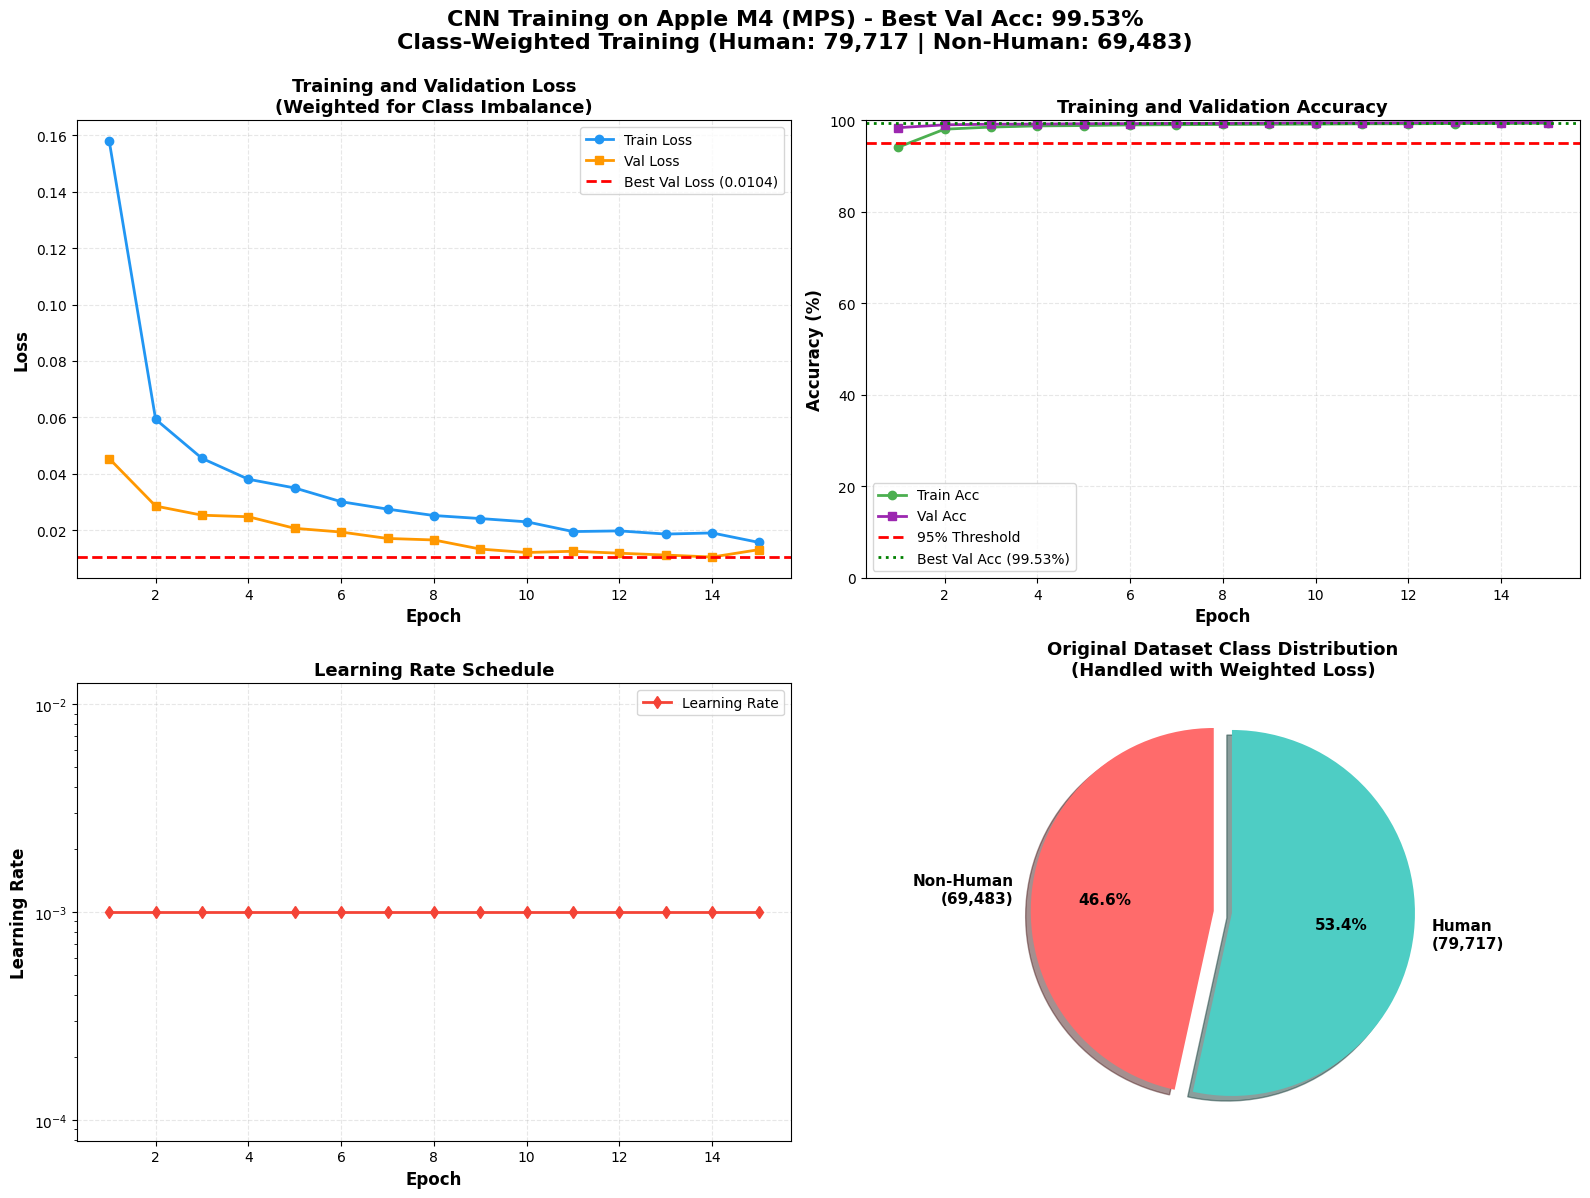


Training history plot saved: /Volumes/Works/Individual_Project/models/training_history_mps.png

Training Summary:
   Total epochs: 15
   Best epoch: 14
   Final train acc: 99.37%
   Final val acc: 99.53%
   Best val acc: 99.53%
   Final LR: 0.001000

Class Imbalance Handled:
   Used weighted CrossEntropyLoss
   Non-Human weight: 1.0686
   Human weight: 0.9314


In [8]:
# Cell 8: Visualize training history (Enhanced with class info)

print("Visualizing Training History")

# Create figure with 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

epochs_range = range(1, len(history['train_loss']) + 1)

# Plot 1: Training and validation loss over epochs
axes[0, 0].plot(epochs_range, history['train_loss'], 'o-', label='Train Loss', 
                linewidth=2, markersize=6, color='#2196F3')
axes[0, 0].plot(epochs_range, history['val_loss'], 's-', label='Val Loss', 
                linewidth=2, markersize=6, color='#FF9800')
axes[0, 0].axhline(y=best_val_loss, color='red', linestyle='--', 
                   label=f'Best Val Loss ({best_val_loss:.4f})', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Training and Validation Loss\n(Weighted for Class Imbalance)', 
                     fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10, loc='best')
axes[0, 0].grid(True, alpha=0.3, linestyle='--')

# Plot 2: Training and validation accuracy over epochs
axes[0, 1].plot(epochs_range, history['train_acc'], 'o-', label='Train Acc', 
                linewidth=2, markersize=6, color='#4CAF50')
axes[0, 1].plot(epochs_range, history['val_acc'], 's-', label='Val Acc', 
                linewidth=2, markersize=6, color='#9C27B0')
axes[0, 1].axhline(y=CONFIDENCE_THRESHOLD*100, color='red', linestyle='--', 
                   label=f'{CONFIDENCE_THRESHOLD*100:.0f}% Threshold', linewidth=2)
axes[0, 1].axhline(y=best_val_acc, color='green', linestyle=':', 
                   label=f'Best Val Acc ({best_val_acc:.2f}%)', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Training and Validation Accuracy', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=10, loc='best')
axes[0, 1].grid(True, alpha=0.3, linestyle='--')
axes[0, 1].set_ylim([0, 100])

# Plot 3: Learning rate schedule with adaptive reduction
axes[1, 0].plot(epochs_range, history['learning_rates'], 'd-', label='Learning Rate', 
                linewidth=2, markersize=6, color='#F44336')
axes[1, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Learning Rate Schedule', fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=10, loc='best')
axes[1, 0].grid(True, alpha=0.3, linestyle='--')
axes[1, 0].set_yscale('log')

# Plot 4: Class distribution visualization
class_names = [f'Non-Human\n({class_counts[0]:,})', f'Human\n({class_counts[1]:,})']
class_sizes = [class_counts[0], class_counts[1]]
colors = ['#FF6B6B', '#4ECDC4']
explode = (0.05, 0.05)

axes[1, 1].pie(class_sizes, explode=explode, labels=class_names, colors=colors,
               autopct='%1.1f%%', shadow=True, startangle=90,
               textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1, 1].set_title('Original Dataset Class Distribution\n(Handled with Weighted Loss)', 
                     fontsize=13, fontweight='bold')

# Add overall figure title with key metrics
fig.suptitle(f'CNN Training on Apple M4 (MPS) - Best Val Acc: {best_val_acc:.2f}%\n' + 
             f'Class-Weighted Training (Human: {class_counts[1]:,} | Non-Human: {class_counts[0]:,})', 
             fontsize=16, fontweight='bold', y=0.995)

# Adjust layout and save figure
plt.tight_layout()
plot_path = MODEL_DIR / "training_history_mps.png"
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

# Display training summary statistics
print(f"\nTraining history plot saved: {plot_path}")
print(f"\nTraining Summary:")
print(f"   Total epochs: {len(history['train_loss'])}")
print(f"   Best epoch: {history['val_loss'].index(min(history['val_loss'])) + 1}")
print(f"   Final train acc: {history['train_acc'][-1]:.2f}%")
print(f"   Final val acc: {history['val_acc'][-1]:.2f}%")
print(f"   Best val acc: {best_val_acc:.2f}%")
print(f"   Final LR: {history['learning_rates'][-1]:.6f}")
print(f"\nClass Imbalance Handled:")
print(f"   Used weighted CrossEntropyLoss")
print(f"   Non-Human weight: {class_weights[0].item():.4f}")
print(f"   Human weight: {class_weights[1].item():.4f}")

In [9]:
# Cell 9: Detailed Confusion Matrix Analysis

print("Detailed Confusion Matrix Analysis")

# Load best model checkpoint for evaluation
if 'checkpoint' not in locals():
    checkpoint = torch.load(best_model_path, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

print(f"\nModel loaded from epoch {checkpoint['epoch']+1}")
print(f"  Val Loss: {checkpoint['val_loss']:.4f}")
print(f"  Val Acc: {checkpoint['val_acc']:.2f}%")

# Initialize containers for predictions and labels
all_labels = []
all_predictions = []
all_probs = []
all_confidences = []

print(f"\nEvaluating on Validation Set")
print(f"Validation samples: {len(val_dataset):,}")

# Generate predictions on validation set
with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Evaluating", leave=True):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        # Forward pass with softmax for probability distribution
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        confidences, predicted = torch.max(probs, 1)
        
        # Collect results for analysis
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_confidences.extend(confidences.cpu().numpy())

# Convert lists to numpy arrays for efficient computation
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probs = np.array(all_probs)
all_confidences = np.array(all_confidences)

# Calculate overall accuracy
overall_acc = 100 * np.sum(all_labels == all_predictions) / len(all_labels)

# Partition predictions by confidence threshold
high_conf_mask = all_confidences >= CONFIDENCE_THRESHOLD
low_conf_mask = all_confidences < CONFIDENCE_THRESHOLD

high_conf_labels = all_labels[high_conf_mask]
high_conf_predictions = all_predictions[high_conf_mask]
low_conf_labels = all_labels[low_conf_mask]
low_conf_predictions = all_predictions[low_conf_mask]

# Calculate accuracy for each confidence group
if len(high_conf_labels) > 0:
    high_conf_acc = 100 * np.sum(high_conf_labels == high_conf_predictions) / len(high_conf_labels)
else:
    high_conf_acc = 0

if len(low_conf_labels) > 0:
    low_conf_acc = 100 * np.sum(low_conf_labels == low_conf_predictions) / len(low_conf_labels)
else:
    low_conf_acc = 0

# Display overall performance metrics
print(f"\nOverall Performance")
print(f"Total samples: {len(all_labels):,}")
print(f"Overall accuracy: {overall_acc:.2f}%")
print(f"Mean confidence: {np.mean(all_confidences):.4f}")
print(f"Median confidence: {np.median(all_confidences):.4f}")

print(f"\nHigh Confidence Performance (>={CONFIDENCE_THRESHOLD*100:.0f}%)")
print(f"Samples: {len(high_conf_labels):,} ({100*len(high_conf_labels)/len(all_labels):.2f}%)")
print(f"Accuracy: {high_conf_acc:.2f}%")
if len(high_conf_labels) > 0:
    print(f"Mean confidence: {np.mean(all_confidences[high_conf_mask]):.4f}")

print(f"\nLow Confidence Performance (<{CONFIDENCE_THRESHOLD*100:.0f}%)")
print(f"Samples: {len(low_conf_labels):,} ({100*len(low_conf_labels)/len(all_labels):.2f}%)")
print(f"Accuracy: {low_conf_acc:.2f}%")
if len(low_conf_labels) > 0:
    print(f"Mean confidence: {np.mean(all_confidences[low_conf_mask]):.4f}")

# Generate confusion matrices for different confidence levels
cm_overall = confusion_matrix(all_labels, all_predictions)
if len(high_conf_labels) > 0:
    cm_high_conf = confusion_matrix(high_conf_labels, high_conf_predictions)
else:
    cm_high_conf = np.zeros((2, 2))

if len(low_conf_labels) > 0:
    cm_low_conf = confusion_matrix(low_conf_labels, low_conf_predictions)
else:
    cm_low_conf = np.zeros((2, 2))

# Calculate detailed per-class metrics
print(f"\nPer-Class Detailed Metrics")

class_names = ['Non-Human', 'Human']

for i, class_name in enumerate(class_names):
    # Extract confusion matrix components
    tp = cm_overall[i, i]  # True Positives
    fp = cm_overall[:, i].sum() - tp  # False Positives
    fn = cm_overall[i, :].sum() - tp  # False Negatives
    tn = cm_overall.sum() - tp - fp - fn  # True Negatives
    
    # Compute classification metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"\n{class_name} (Class {i}):")
    print(f"  Samples in validation: {(all_labels == i).sum():,}")
    print(f"  True Positives:  {tp:,}")
    print(f"  False Positives: {fp:,}")
    print(f"  True Negatives:  {tn:,}")
    print(f"  False Negatives: {fn:,}")
    print(f"  Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"  Recall:    {recall:.4f} ({recall*100:.2f}%)")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  Specificity: {specificity:.4f} ({specificity*100:.2f}%)")

# Generate comprehensive classification report
print(f"\nSklearn Classification Report")
print(classification_report(
    all_labels,
    all_predictions,
    target_names=class_names,
    digits=4
))

# Display confusion matrices in tabular format
print(f"\nConfusion Matrix Breakdown")

print(f"\nOverall Confusion Matrix:")
print(f"                    Predicted")
print(f"                Non-Human    Human")
print(f"Actual Non-Human    {cm_overall[0,0]:6,}    {cm_overall[0,1]:6,}")
print(f"       Human        {cm_overall[1,0]:6,}    {cm_overall[1,1]:6,}")

if len(high_conf_labels) > 0:
    print(f"\nHigh Confidence (>={CONFIDENCE_THRESHOLD*100:.0f}%) Confusion Matrix:")
    print(f"                    Predicted")
    print(f"                Non-Human    Human")
    print(f"Actual Non-Human    {cm_high_conf[0,0]:6,}    {cm_high_conf[0,1]:6,}")
    print(f"       Human        {cm_high_conf[1,0]:6,}    {cm_high_conf[1,1]:6,}")

if len(low_conf_labels) > 0:
    print(f"\nLow Confidence (<{CONFIDENCE_THRESHOLD*100:.0f}%) Confusion Matrix:")
    print(f"                    Predicted")
    print(f"                Non-Human    Human")
    print(f"Actual Non-Human    {cm_low_conf[0,0]:6,}    {cm_low_conf[0,1]:6,}")
    print(f"       Human        {cm_low_conf[1,0]:6,}    {cm_low_conf[1,1]:6,}")

# Analyze prediction errors
print(f"\nError Analysis")

# Analyze false positives: predicted Human but actually Non-Human
fp_human_mask = (all_predictions == 1) & (all_labels == 0)
fp_human_count = fp_human_mask.sum()
if fp_human_count > 0:
    fp_human_conf = all_confidences[fp_human_mask]
    print(f"\nFalse Positives (Predicted Human, Actually Non-Human):")
    print(f"  Count: {fp_human_count:,}")
    print(f"  Mean confidence: {fp_human_conf.mean():.4f}")
    print(f"  Min confidence: {fp_human_conf.min():.4f}")
    print(f"  Max confidence: {fp_human_conf.max():.4f}")
    print(f"  Above {CONFIDENCE_THRESHOLD*100:.0f}% threshold: {(fp_human_conf >= CONFIDENCE_THRESHOLD).sum():,}")

# Analyze false negatives: predicted Non-Human but actually Human
fn_human_mask = (all_predictions == 0) & (all_labels == 1)
fn_human_count = fn_human_mask.sum()
if fn_human_count > 0:
    fn_human_conf = all_confidences[fn_human_mask]
    print(f"\nFalse Negatives (Predicted Non-Human, Actually Human):")
    print(f"  Count: {fn_human_count:,}")
    print(f"  Mean confidence: {fn_human_conf.mean():.4f}")
    print(f"  Min confidence: {fn_human_conf.min():.4f}")
    print(f"  Max confidence: {fn_human_conf.max():.4f}")
    print(f"  Above {CONFIDENCE_THRESHOLD*100:.0f}% threshold: {(fn_human_conf >= CONFIDENCE_THRESHOLD).sum():,}")

# Analyze confidence distribution across prediction ranges
print(f"\nConfidence Distribution")

confidence_ranges = [
    (0.0, 0.5, "Very Low (0-50%)"),
    (0.5, 0.7, "Low (50-70%)"),
    (0.7, 0.9, "Medium (70-90%)"),
    (0.9, 0.95, "High (90-95%)"),
    (0.95, 1.0, "Very High (95-100%)")
]

for low, high, label in confidence_ranges:
    mask = (all_confidences >= low) & (all_confidences < high)
    count = mask.sum()
    if count > 0:
        acc = 100 * np.sum(all_labels[mask] == all_predictions[mask]) / count
        print(f"\n{label}:")
        print(f"  Samples: {count:,} ({100*count/len(all_labels):.2f}%)")
        print(f"  Accuracy: {acc:.2f}%")

Detailed Confusion Matrix Analysis

Model loaded from epoch 14
  Val Loss: 0.0104
  Val Acc: 99.53%

Evaluating on Validation Set
Validation samples: 37,300


Evaluating:   0%|          | 0/292 [00:00<?, ?it/s]


Overall Performance
Total samples: 37,300
Overall accuracy: 99.53%
Mean confidence: 0.9951
Median confidence: 1.0000

High Confidence Performance (>=95%)
Samples: 36,731 (98.47%)
Accuracy: 99.96%
Mean confidence: 0.9997

Low Confidence Performance (<95%)
Samples: 569 (1.53%)
Accuracy: 71.70%
Mean confidence: 0.6954

Per-Class Detailed Metrics

Non-Human (Class 0):
  Samples in validation: 17,517
  True Positives:  17,476
  False Positives: 136
  True Negatives:  19,647
  False Negatives: 41
  Precision: 0.9923 (99.23%)
  Recall:    0.9977 (99.77%)
  F1-Score:  0.9950
  Specificity: 0.9931 (99.31%)

Human (Class 1):
  Samples in validation: 19,783
  True Positives:  19,647
  False Positives: 41
  True Negatives:  17,476
  False Negatives: 136
  Precision: 0.9979 (99.79%)
  Recall:    0.9931 (99.31%)
  F1-Score:  0.9955
  Specificity: 0.9977 (99.77%)

Sklearn Classification Report
              precision    recall  f1-score   support

   Non-Human     0.9923    0.9977    0.9950     1751

Visualizing Confusion Matrices


/var/folders/tx/7t04ldvx3gjgk2kyq5t8_vkr0000gn/T/ipykernel_1211/461226530.py:120: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax6.boxplot(box_data, labels=['Correct', 'Incorrect'], patch_artist=True,
/var/folders/tx/7t04ldvx3gjgk2kyq5t8_vkr0000gn/T/ipykernel_1211/461226530.py:205: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


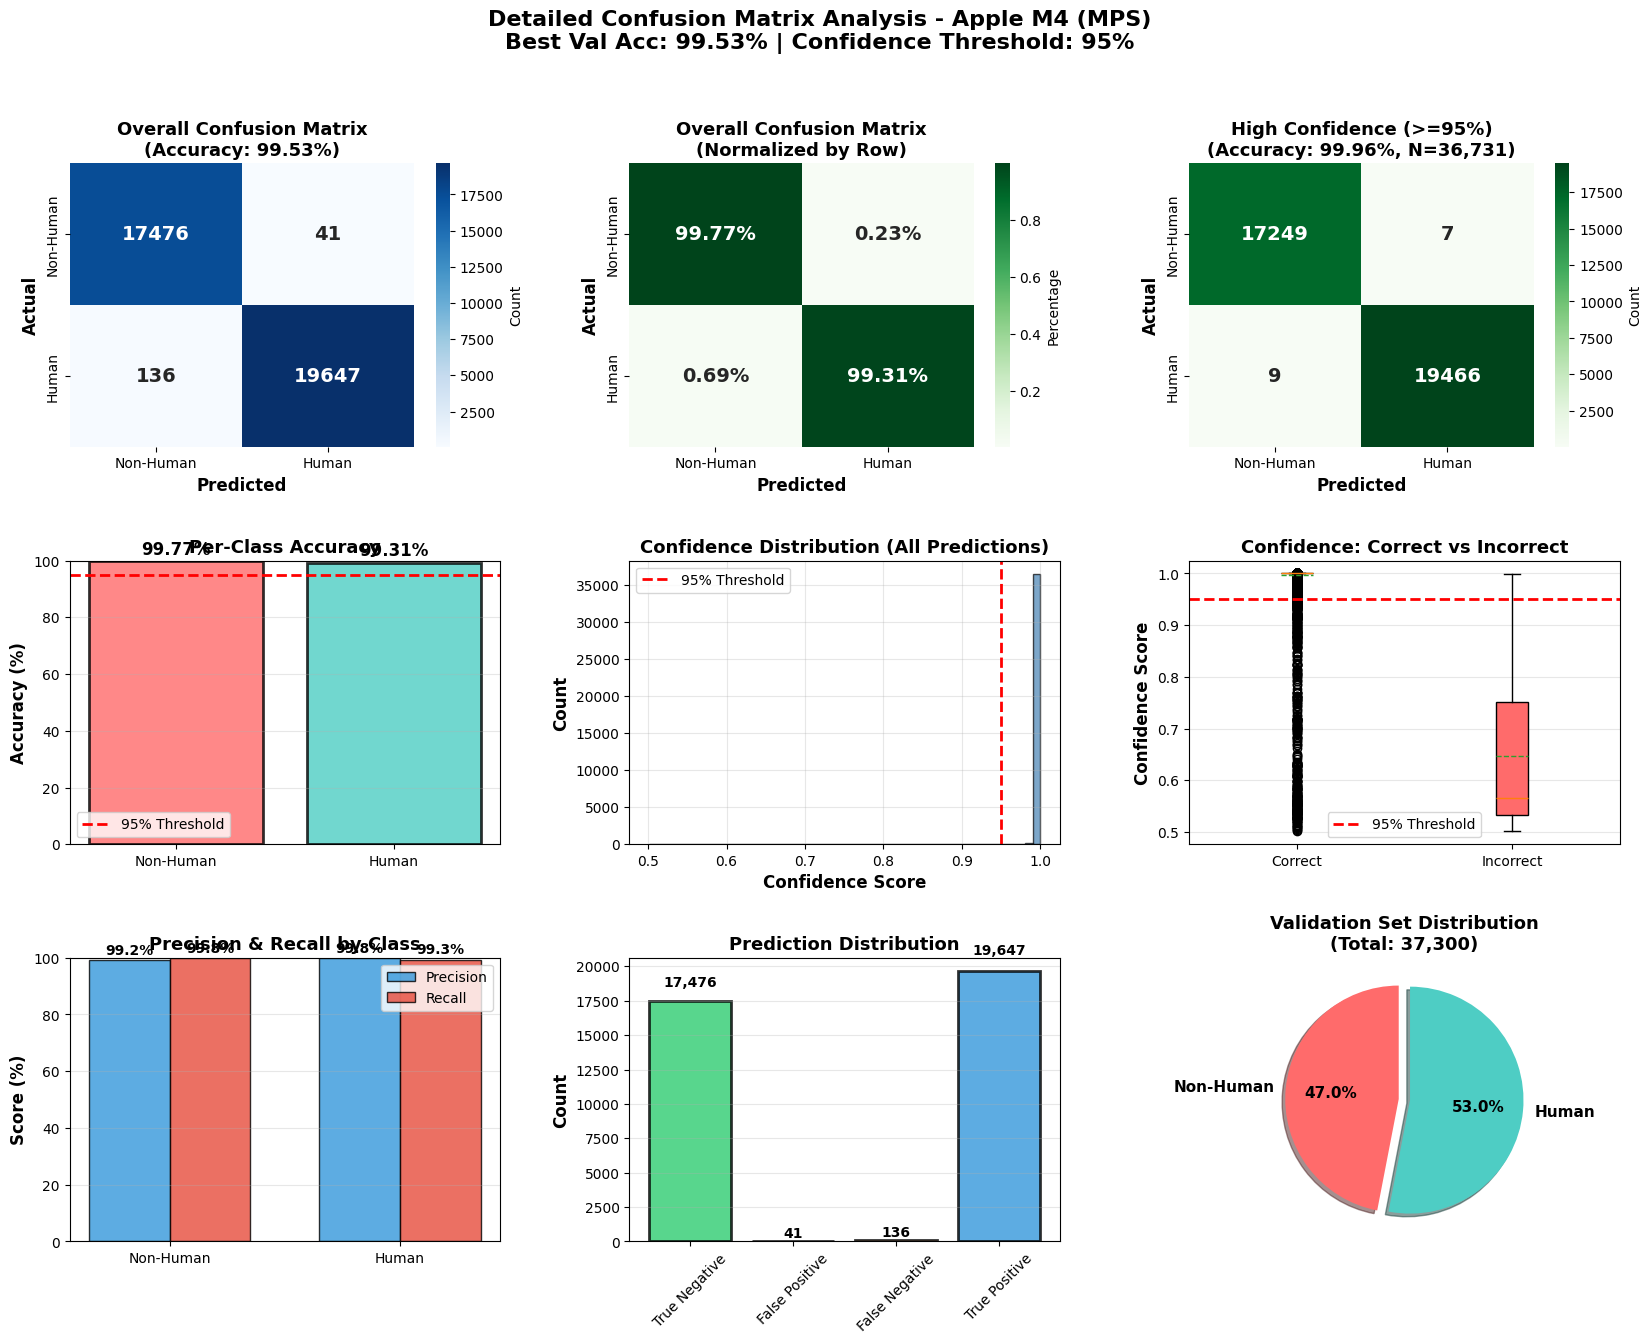


Detailed confusion matrix plot saved: /Volumes/Works/Individual_Project/models/confusion_matrix_detailed_mps.png

Analysis Complete


In [10]:
# Cell 10: Visualize Detailed Confusion Matrices

print("Visualizing Confusion Matrices")

# Create figure with complex grid layout for multiple visualizations
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.3)

class_names = ['Non-Human', 'Human']

# Plot 1: Overall confusion matrix with raw counts
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(
    cm_overall,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    ax=ax1,
    cbar_kws={'label': 'Count'},
    annot_kws={'fontsize': 14, 'fontweight': 'bold'}
)
ax1.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax1.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax1.set_title(f'Overall Confusion Matrix\n(Accuracy: {overall_acc:.2f}%)', 
              fontsize=13, fontweight='bold')

# Plot 2: Normalized confusion matrix showing percentages
ax2 = fig.add_subplot(gs[0, 1])
cm_normalized = cm_overall.astype('float') / cm_overall.sum(axis=1)[:, np.newaxis]
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2%',
    cmap='Greens',
    xticklabels=class_names,
    yticklabels=class_names,
    ax=ax2,
    cbar_kws={'label': 'Percentage'},
    annot_kws={'fontsize': 14, 'fontweight': 'bold'}
)
ax2.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax2.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax2.set_title('Overall Confusion Matrix\n(Normalized by Row)', 
              fontsize=13, fontweight='bold')

# Plot 3: High confidence predictions confusion matrix
ax3 = fig.add_subplot(gs[0, 2])
if len(high_conf_labels) > 0:
    sns.heatmap(
        cm_high_conf,
        annot=True,
        fmt='d',
        cmap='Greens',
        xticklabels=class_names,
        yticklabels=class_names,
        ax=ax3,
        cbar_kws={'label': 'Count'},
        annot_kws={'fontsize': 14, 'fontweight': 'bold'}
    )
    ax3.set_title(f'High Confidence (>={CONFIDENCE_THRESHOLD*100:.0f}%)\n' + 
                  f'(Accuracy: {high_conf_acc:.2f}%, N={len(high_conf_labels):,})', 
                  fontsize=13, fontweight='bold')
else:
    ax3.text(0.5, 0.5, 'No high confidence\npredictions', 
            ha='center', va='center', fontsize=14)
    ax3.set_title(f'High Confidence (>={CONFIDENCE_THRESHOLD*100:.0f}%)', 
                  fontsize=13, fontweight='bold')
ax3.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax3.set_ylabel('Actual', fontsize=12, fontweight='bold')

# Plot 4: Per-class accuracy comparison bar chart
ax4 = fig.add_subplot(gs[1, 0])
class_accuracies = []
for i in range(2):
    mask = all_labels == i
    if mask.sum() > 0:
        acc = 100 * np.sum(all_predictions[mask] == i) / mask.sum()
        class_accuracies.append(acc)
    else:
        class_accuracies.append(0)

bars = ax4.bar(class_names, class_accuracies, color=['#FF6B6B', '#4ECDC4'], 
               alpha=0.8, edgecolor='black', linewidth=2)
ax4.axhline(y=CONFIDENCE_THRESHOLD*100, color='red', linestyle='--', 
           label=f'{CONFIDENCE_THRESHOLD*100:.0f}% Threshold', linewidth=2)
ax4.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax4.set_title('Per-Class Accuracy', fontsize=13, fontweight='bold')
ax4.set_ylim([0, 100])
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

# Add accuracy values on top of bars
for bar, acc in zip(bars, class_accuracies):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{acc:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Plot 5: Distribution of confidence scores
ax5 = fig.add_subplot(gs[1, 1])
ax5.hist(all_confidences, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax5.axvline(x=CONFIDENCE_THRESHOLD, color='red', linestyle='--', 
           label=f'{CONFIDENCE_THRESHOLD*100:.0f}% Threshold', linewidth=2)
ax5.set_xlabel('Confidence Score', fontsize=12, fontweight='bold')
ax5.set_ylabel('Count', fontsize=12, fontweight='bold')
ax5.set_title('Confidence Distribution (All Predictions)', fontsize=13, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3)

# Plot 6: Box plot comparing confidence for correct vs incorrect predictions
ax6 = fig.add_subplot(gs[1, 2])
correct_mask = all_labels == all_predictions
incorrect_mask = ~correct_mask

correct_conf = all_confidences[correct_mask]
incorrect_conf = all_confidences[incorrect_mask]

box_data = [correct_conf, incorrect_conf]
bp = ax6.boxplot(box_data, labels=['Correct', 'Incorrect'], patch_artist=True,
                showmeans=True, meanline=True)
bp['boxes'][0].set_facecolor('#4ECDC4')
bp['boxes'][1].set_facecolor('#FF6B6B')
ax6.axhline(y=CONFIDENCE_THRESHOLD, color='red', linestyle='--', 
           label=f'{CONFIDENCE_THRESHOLD*100:.0f}% Threshold', linewidth=2)
ax6.set_ylabel('Confidence Score', fontsize=12, fontweight='bold')
ax6.set_title('Confidence: Correct vs Incorrect', fontsize=13, fontweight='bold')
ax6.legend(fontsize=10)
ax6.grid(True, alpha=0.3, axis='y')

# Plot 7: Precision and recall comparison by class
ax7 = fig.add_subplot(gs[2, 0])
precisions = []
recalls = []
for i in range(2):
    tp = cm_overall[i, i]
    fp = cm_overall[:, i].sum() - tp
    fn = cm_overall[i, :].sum() - tp
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    precisions.append(precision * 100)
    recalls.append(recall * 100)

x = np.arange(len(class_names))
width = 0.35

bars1 = ax7.bar(x - width/2, precisions, width, label='Precision', 
               color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax7.bar(x + width/2, recalls, width, label='Recall', 
               color='#e74c3c', alpha=0.8, edgecolor='black')

ax7.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
ax7.set_title('Precision & Recall by Class', fontsize=13, fontweight='bold')
ax7.set_xticks(x)
ax7.set_xticklabels(class_names)
ax7.legend(fontsize=10)
ax7.set_ylim([0, 100])
ax7.grid(True, alpha=0.3, axis='y')

# Add metric values on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 8: Distribution of prediction types
ax8 = fig.add_subplot(gs[2, 1])
error_types = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
error_counts = [cm_overall[0,0], cm_overall[0,1], cm_overall[1,0], cm_overall[1,1]]
colors_error = ['#2ecc71', '#e74c3c', '#e67e22', '#3498db']

bars = ax8.bar(error_types, error_counts, color=colors_error, alpha=0.8, 
               edgecolor='black', linewidth=2)
ax8.set_ylabel('Count', fontsize=12, fontweight='bold')
ax8.set_title('Prediction Distribution', fontsize=13, fontweight='bold')
ax8.tick_params(axis='x', rotation=45)
ax8.grid(True, alpha=0.3, axis='y')

# Add count labels on bars
for bar, count in zip(bars, error_counts):
    height = bar.get_height()
    ax8.text(bar.get_x() + bar.get_width()/2., height + height*0.05,
            f'{count:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 9: Validation set class distribution pie chart
ax9 = fig.add_subplot(gs[2, 2])
class_counts_val = [(all_labels == 0).sum(), (all_labels == 1).sum()]
explode = (0.05, 0.05)
colors_pie = ['#FF6B6B', '#4ECDC4']

ax9.pie(class_counts_val, explode=explode, labels=class_names, colors=colors_pie,
       autopct='%1.1f%%', shadow=True, startangle=90,
       textprops={'fontsize': 11, 'fontweight': 'bold'})
ax9.set_title(f'Validation Set Distribution\n(Total: {len(all_labels):,})', 
             fontsize=13, fontweight='bold')

# Add overall figure title with key metrics
fig.suptitle(f'Detailed Confusion Matrix Analysis - Apple M4 (MPS)\n' + 
             f'Best Val Acc: {best_val_acc:.2f}% | Confidence Threshold: {CONFIDENCE_THRESHOLD*100:.0f}%', 
             fontsize=16, fontweight='bold', y=0.99)

plt.tight_layout()

# Save high-resolution figure
cm_plot_path = MODEL_DIR / "confusion_matrix_detailed_mps.png"
plt.savefig(cm_plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\nDetailed confusion matrix plot saved: {cm_plot_path}")
print(f"\nAnalysis Complete")

Creating Simple Confusion Matrix


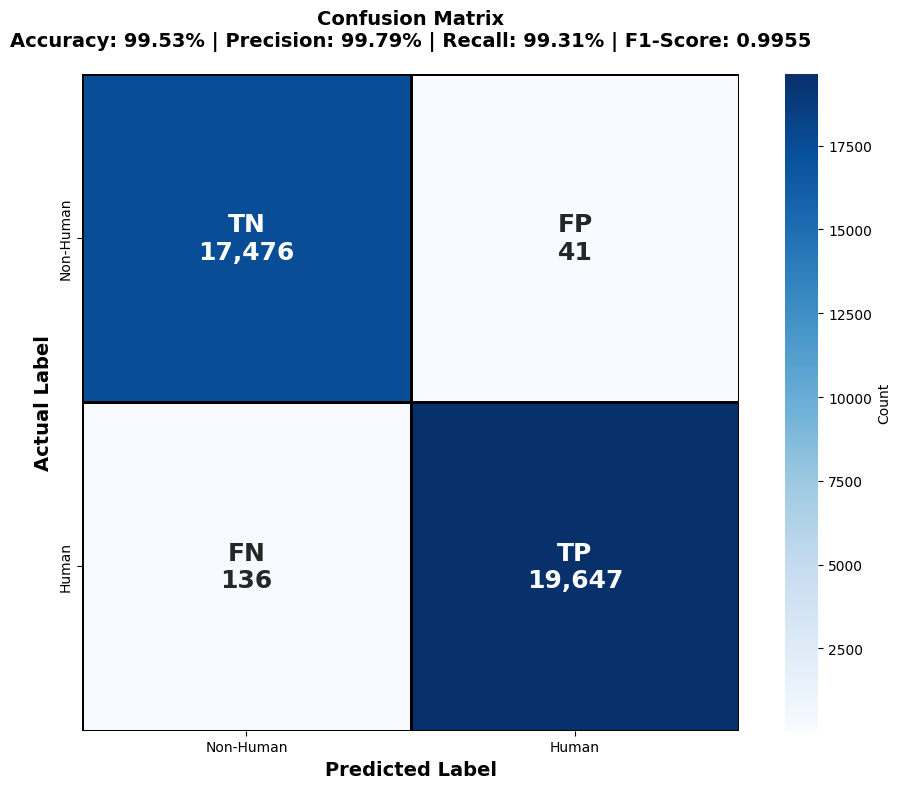


CONFUSION MATRIX SUMMARY

True Positives (TP):   19,647
True Negatives (TN):   17,476
False Positives (FP):  41
False Negatives (FN):  136

Total Predictions:     37,300

PERFORMANCE METRICS

Accuracy:  99.53%
Precision: 99.79%
Recall:    99.31%
F1-Score:  0.9955

Simple confusion matrix saved: /Volumes/Works/Individual_Project/models/confusion_matrix_simple.png


In [14]:
# Simple Confusion Matrix with TP, TN, FP, FN, and F1 Score

print("Creating Simple Confusion Matrix")

# Extract TP, TN, FP, FN from confusion matrix
TN = cm_overall[0, 0]  # True Negative
FP = cm_overall[0, 1]  # False Positive
FN = cm_overall[1, 0]  # False Negative
TP = cm_overall[1, 1]  # True Positive

# Calculate metrics
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Create single figure
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Create custom annotations for confusion matrix
annotations = np.array([
    [f'TN\n{TN:,}', f'FP\n{FP:,}'],
    [f'FN\n{FN:,}', f'TP\n{TP:,}']
])

# Create heatmap
sns.heatmap(
    cm_overall,
    annot=annotations,
    fmt='',
    cmap='Blues',
    xticklabels=['Non-Human', 'Human'],
    yticklabels=['Non-Human', 'Human'],
    ax=ax,
    cbar_kws={'label': 'Count'},
    annot_kws={'fontsize': 18, 'fontweight': 'bold'},
    linewidths=2,
    linecolor='black',
    square=True
)

ax.set_xlabel('Predicted Label', fontsize=14, fontweight='bold')
ax.set_ylabel('Actual Label', fontsize=14, fontweight='bold')

# Add title with metrics
title_text = f'Confusion Matrix\n'
title_text += f'Accuracy: {accuracy*100:.2f}% | Precision: {precision*100:.2f}% | Recall: {recall*100:.2f}% | F1-Score: {f1_score:.4f}'
ax.set_title(title_text, fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()

# Save figure
cm_simple_path = MODEL_DIR / "confusion_matrix_simple.png"
plt.savefig(cm_simple_path, dpi=150, bbox_inches='tight')
plt.show()

# Print summary
print(f"\n{'='*60}")
print("CONFUSION MATRIX SUMMARY")
print(f"{'='*60}")
print(f"\nTrue Positives (TP):   {TP:,}")
print(f"True Negatives (TN):   {TN:,}")
print(f"False Positives (FP):  {FP:,}")
print(f"False Negatives (FN):  {FN:,}")
print(f"\nTotal Predictions:     {TP+TN+FP+FN:,}")
print(f"\n{'='*60}")
print("PERFORMANCE METRICS")
print(f"{'='*60}")
print(f"\nAccuracy:  {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall:    {recall*100:.2f}%")
print(f"F1-Score:  {f1_score:.4f}")
print(f"\n{'='*60}")
print(f"Simple confusion matrix saved: {cm_simple_path}")
print(f"{'='*60}")
